# **LAB: SUBSET SELECTION METHODS**
Packages used:
 - `statsmodels` is meant for "conducting statistical tests, and statistical data exploration" it is technically more similar to R in its function, syntax and general use;
 - `sklearn` is meant for prediction; knowledge of scikit-learn is a very valuable skill nowadays, so I thought it best to include it;
 - and of course, `pandas` for data wrangling and organizing, as well as `matplotlib` and `seaborn` for pictures.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from itertools import combinations
import time


sns.set_theme(style="darkgrid")

---
## **1. Best Subset Selection**
We apply subset selection methods to the `Hitters` data, which contains statistics about baseball players; we want to predict a player's salary based on their performances in the previous year.

In [2]:
hitters = pd.read_csv('data/Hitters.csv')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


Note that the `Salary` variable is missing (written as `NaN`) for 59 players:

In [3]:
hitters['Salary'].isna().sum()

59

Let's drop those rows for which we don't have `Salary` information.

In [4]:
hitters.dropna(subset=['Salary'], inplace=True)
hitters = pd.get_dummies(hitters, drop_first=True)
X = hitters.drop(columns='Salary')
y = hitters['Salary']

`sklearn` doesn't support "brute force" best subset selection natively, so we'll have to implement it ourselves. 

We do this in two steps: first, we compare models with a given number of predictors and chose the best one. We'll then use cross-validation to compare the best models for each size.


To implement the first step, we use the `combinations(l,k)` function from the `itertools` module, which gives us all combinations of $k$ elements from the list `l`. We pass it the list `range(p)`, which corresponds to the list $0, \ldots, p-1$ of indices of columns in our dataframe $X$, and it returns all subsets of this list of size $k$. 

We then fit our model using the columns corresponding to each subset, and select the best model according to our metric (by default, `sklearn` uses $R^2$ for linear regression). 

In [5]:
def best_subset_k(estimator, X, y, k):
    p = X.shape[1]
    all_subsets = combinations(range(p), k)  # list of all subsets of (0, 1, ..., p) of size k.
    
    best_subset = []
    best_score = -np.inf
    for subset in all_subsets:
        estimator.fit(X.iloc[:, list(subset)], y)
        score = estimator.score(X.iloc[:, list(subset)], y)
        if score > best_score:
            best_subset, best_score = subset, score
    
    return best_subset, best_score
        

Let's test this!

_Note: this could take several minutes to run unless you have a fancy computer._

In [6]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

scores = []
best_subsets = []
for k in range(1, 9):
    subset, score = best_subset_k(linreg, X, y, k)
    print('k =', k, 'R^2 =', f"{score:.3f}")
    scores.append(score)
    best_subsets.append(subset)
    
print(scores)
print(best_subsets)

k = 1 R^2 = 0.321
k = 2 R^2 = 0.425
k = 3 R^2 = 0.451
k = 4 R^2 = 0.475
k = 5 R^2 = 0.491
k = 6 R^2 = 0.509
k = 7 R^2 = 0.514
k = 8 R^2 = 0.529
[0.3214500886678947, 0.42522374646677885, 0.45142941571795725, 0.47540665339478694, 0.4908036159635183, 0.5087145573589966, 0.5141226823612731, 0.5285568603025744]
[(11,), (1, 11), (1, 11, 13), (1, 11, 13, 17), (0, 1, 11, 13, 17), (0, 1, 5, 11, 13, 17), (1, 5, 7, 8, 9, 13, 17), (0, 1, 5, 9, 10, 12, 13, 17)]


In [7]:
best_subsets

[(11,),
 (1, 11),
 (1, 11, 13),
 (1, 11, 13, 17),
 (0, 1, 11, 13, 17),
 (0, 1, 5, 11, 13, 17),
 (1, 5, 7, 8, 9, 13, 17),
 (0, 1, 5, 9, 10, 12, 13, 17)]

As anticipated, $R^2$ grows with the number of variables. To compare these subsets, we might want to use adjusted $R^2$, $RSS$, $C_p$ or $BIC$.

We'll need the help of `statsmodels` for these.

In [8]:
X_sm = sm.add_constant(X, prepend = False)

all_scores = []
for subset in best_subsets:
    linreg_sm = sm.OLS(y, X_sm.iloc[:, list(subset)+[X_sm.shape[1] - 1]])
    linreg_sm = linreg_sm.fit()
    all_scores.append([len(subset), linreg_sm.ssr, 
                       linreg_sm.rsquared_adj, linreg_sm.aic, linreg_sm.bic])
    print('k =', len(subset), 
         '\nRSS:', linreg_sm.ssr,
         '\nAdj. R^2:', linreg_sm.rsquared_adj,
         '\nAIC:', linreg_sm.aic,
         '\nBIC:', linreg_sm.bic, '\n')

k = 1 
RSS: 36179679.25504183 
Adj. R^2: 0.3188502805784995 
AIC: 3862.1393074062353 
BIC: 3869.283615470591 

k = 2 
RSS: 30646559.89037283 
Adj. R^2: 0.4208023906703695 
AIC: 3820.487304575255 
BIC: 3831.2037666717883 

k = 3 
RSS: 29249296.855867323 
Adj. R^2: 0.44507531628611885 
AIC: 3810.214440261381 
BIC: 3824.503056390092 

k = 4 
RSS: 27970851.815816276 
Adj. R^2: 0.4672734232148611 
AIC: 3800.4602935887474 
BIC: 3818.3210637496363 

k = 5 
RSS: 27149899.43201154 
Adj. R^2: 0.4808970715270109 
AIC: 3794.62562374912 
BIC: 3816.058547942187 

k = 6 
RSS: 26194903.927595213 
Adj. R^2: 0.49720005479709806 
AIC: 3787.207999572956 
BIC: 3812.2130777982 

k = 7 
RSS: 25906547.500623744 
Adj. R^2: 0.5007848736417786 
AIC: 3786.296813317884 
BIC: 3814.874045575306 

k = 8 
RSS: 25136929.938960124 
Adj. R^2: 0.5137082574774585 
AIC: 3780.3653490320316 
BIC: 3812.5147353216316 



Let's plot the different scorers to visualize the impact of our feature selection:

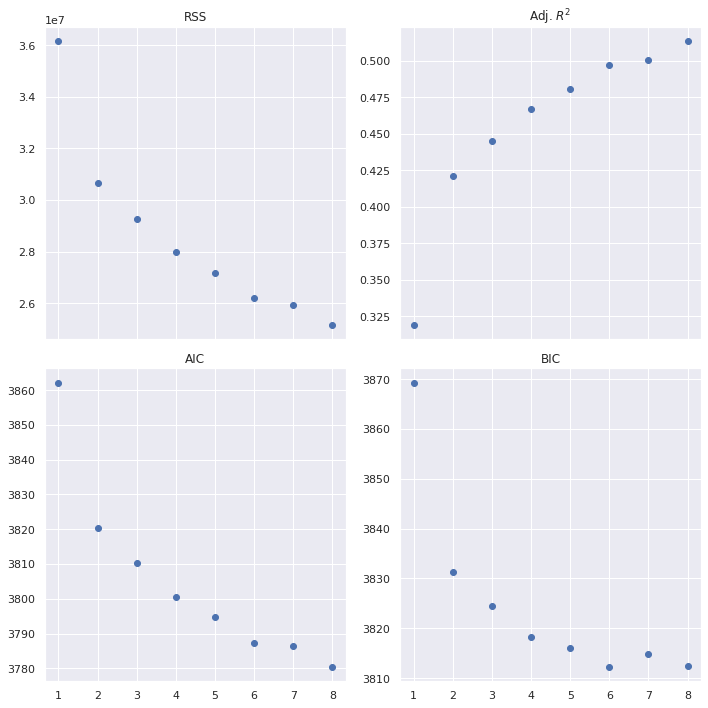

In [9]:
all_scores = np.array(all_scores)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True)
ax1, ax2, ax3, ax4 = axes.flat

ax1.scatter(all_scores[:,0], all_scores[:,1])
ax1.set(title='RSS')

ax2.scatter(all_scores[:,0], all_scores[:,2])
ax2.set(title='Adj. $R^2$')

ax3.scatter(all_scores[:,0], all_scores[:,3])
ax3.set(title='AIC')

ax4.scatter(all_scores[:,0], all_scores[:,4])
ax4.set(title='BIC')


fig.tight_layout()

From these graphs, it looks like the model's fit improves up till 6 features, but there's not much improvement past that. Looks like our 6 featured-model is the best one. Here is the corresponding dataset:

In [10]:
X.iloc[:, list(best_subsets[5])].head()

,AtBat,Hits,Walks,CRBI,PutOuts,Division_W
1,315,81,39,414,632,1
2,479,130,76,266,880,1
3,496,141,37,838,200,0
4,321,87,30,46,805,0
5,594,169,35,336,282,1


---
## **2. Forward and backward stepwise selection**

Two other methods that do not exist in `sklearn`. Let's implement forward stepwise selection, using $R^2$ as our selection metric. We first make a function that, given a set of predictors, chooses the additional predictor that improves the model the most, then loop through the function.

In [11]:
def forward_step(estimator, X, y, predictors=[]):
    remaining = [i for i in range(X.shape[1]) if i not in predictors]
    
    best_score = -np.inf
    best_feature = None
    for i in remaining:
        linreg.fit(X.iloc[:, predictors + [i]], y)
        score = linreg.score(X.iloc[:, predictors + [i]], y)
        if score > best_score:
            best_score, best_feature = score, i
            
    predictors.append(best_feature)
    return predictors, best_score

In [12]:
def forward_selection(estimator, X, y, k):
    predictors = []
    for _ in range(k):
        predictors, score = forward_step(linreg, X, y, predictors)
    return predictors, score

In [13]:
for k in range(1, 9):
    print(forward_selection(linreg, X, y, k))

([11], 0.3214500886678947)
([11, 1], 0.42522374646677885)
([11, 1, 13], 0.45142941571795725)
([11, 1, 13, 17], 0.47540665339478694)
([11, 1, 13, 17, 0], 0.4908036159635182)
([11, 1, 13, 17, 0, 5], 0.5087145573589968)
([11, 1, 13, 17, 0, 5, 12], 0.5132286393324803)
([11, 1, 13, 17, 0, 5, 12, 10], 0.5281385504329165)


For comparison, here is what we got from best subset selection:

In [14]:
print(best_subsets)
print(scores)

[(11,), (1, 11), (1, 11, 13), (1, 11, 13, 17), (0, 1, 11, 13, 17), (0, 1, 5, 11, 13, 17), (1, 5, 7, 8, 9, 13, 17), (0, 1, 5, 9, 10, 12, 13, 17)]
[0.3214500886678947, 0.42522374646677885, 0.45142941571795725, 0.47540665339478694, 0.4908036159635183, 0.5087145573589966, 0.5141226823612731, 0.5285568603025744]


The first 6 iterations give the same results, but the 7- and 8- feature models are slightly different in best subset selection (the $R^2$ scores are slightly better but not significantly so).

Backwards feature selection is the same, except we loop down. I'll leave it as an exercise.

In [15]:
def back_step(estimator, X, y, predictors=list(range(X.shape[1]))):
        
    best_score = -np.inf
    best_feature = None
    for i in range(len(predictors)):
        copy = predictors.copy()
        copy.pop(i)
        linreg.fit(X.iloc[:, copy], y)
        score = linreg.score(X.iloc[:, copy], y)
        if score > best_score:
            best_score, best_feature = score, i
            
    predictors.pop(best_feature)
    return predictors, best_score

In [16]:
def backward_selection(estimator, X, y, k):
    predictors = list(range(X.shape[1]))
    for _ in range(len(predictors) - k):
        predictors, score = back_step(linreg, X, y, predictors)
    return predictors, score

In [17]:
for k in range(1, 9):
    print(backward_selection(linreg, X, y, k))

([10], 0.316606206461607)
([1, 10], 0.4147790923761453)
([1, 10, 13], 0.44846612094368565)
([0, 1, 10, 13], 0.4664050937014217)
([0, 1, 5, 10, 13], 0.4840588562432552)
([0, 1, 5, 10, 13, 17], 0.49972738619776513)
([0, 1, 5, 10, 12, 13, 17], 0.5136174236566009)
([0, 1, 5, 10, 11, 12, 13, 17], 0.5281385504329165)


We do obtain different results this time.

---
## **3. Choosing among models** 
The method is as follow: we first use a train/test split or a cross-validation method to select the best number $\ell$ of features to include in our model, using MSE as our metric to decide what is "best".

We then perform a best subset selection over all possible subsets of size $\ell$, using the full dataset, to choose our final predictors.  


_Note: The lab in ISLR does this for up to all 19 predictors but I don't want my computer to explode so I'll stick to 8 or less. Feel free to use more predictors if your machine was stolen from NASA._

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.5, 
                                                    random_state=123)

In [19]:
scores_split = []
best_subsets_split = []
for k in range(1, 9):
    subset, score = best_subset_k(linreg, X_train, y_train, k)
    print('k =', k, 'R^2 =', f"{score:.3f}")
    scores_split.append(score)
    best_subsets_split.append(subset)
    
print(scores_split)
print(best_subsets_split)

k = 1 R^2 = 0.440
k = 2 R^2 = 0.492
k = 3 R^2 = 0.519
k = 4 R^2 = 0.533
k = 5 R^2 = 0.548
k = 6 R^2 = 0.556
k = 7 R^2 = 0.565
k = 8 R^2 = 0.571
[0.43960371850356594, 0.49219240555901855, 0.5186165574202177, 0.533219397823149, 0.5478703877024855, 0.5561440320930918, 0.564646336333087, 0.5711548622252366]
[(11,), (11, 13), (11, 13, 17), (6, 11, 13, 17), (6, 10, 11, 13, 17), (2, 5, 6, 11, 13, 17), (2, 5, 6, 8, 9, 13, 17), (2, 5, 7, 8, 9, 13, 14, 17)]


For comparison:

In [20]:
best_subsets

[(11,),
 (1, 11),
 (1, 11, 13),
 (1, 11, 13, 17),
 (0, 1, 11, 13, 17),
 (0, 1, 5, 11, 13, 17),
 (1, 5, 7, 8, 9, 13, 17),
 (0, 1, 5, 9, 10, 12, 13, 17)]

So we already got slightly different subsets with our train/test split. Let's take a look at our MSEs:

In [21]:
test_mses = []
for i in range(8):
    linreg.fit(X_train.iloc[:,list(best_subsets_split[i])], y_train)
    y_pred = linreg.predict(X_test.iloc[:,list(best_subsets_split[i])])
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    test_mses.append(mse)

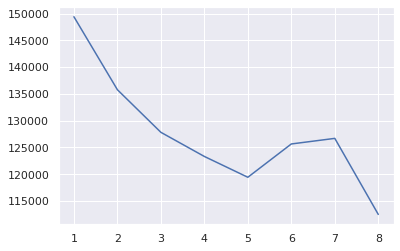

In [22]:
plt.plot(range(1, 9), test_mses);

Looks like the 8-predictor model is superior (note: in ISLR they perform best subset selection on all numbers of predictors and deduce that a 10-predictor model is better. You might want to check that, if your machine can do it).

Last step: now that we know that the best number of features to use, we refit the model using all the variables and extract the best subset. We already did this earlier, so no need to tax our CPU any further.

In [23]:
X.iloc[:, list(best_subsets[7])]

,AtBat,Hits,Walks,CHmRun,CRuns,CWalks,PutOuts,Division_W
1,315,81,39,69,321,375,632,1
2,479,130,76,63,224,263,880,1
3,496,141,37,225,828,354,200,0
4,321,87,30,12,48,33,805,0
5,594,169,35,19,501,194,282,1
...,...,...,...,...,...,...,...,...
317,497,127,37,32,379,138,325,0
318,492,136,94,39,897,875,313,0
319,475,126,52,7,217,146,37,1
320,573,144,78,97,470,332,1314,0


Let's use cross-validation and see if we get a different answer; the following function makes use of our `best_subset_k` function again. It then runs our estimator through a cross-validation using mean squared error as its metric, and returns the best subset of all the ones we evaluated. 

Note that I added an option to pass our already-computed list of best subsets for each $k$ computed according to the test/train split in order to speed up computations.

In [24]:
def best_subset_cv(estimator, X, y, max_size=8, cv=5, best_subsets_k = None):
    
    if not best_subsets_k:  # find the best subset for each k
        p = X.shape[1]  
        best_subsets_k = []
        for k in range(1, min(max_size, p) + 1):  # first select the best subset for each k
            best_subsets_k.append(best_subset_k(estimator, X, y, k)[0])

    kfold = sklearn.model_selection.KFold(cv, random_state=123, shuffle=True)
    best_subset = None
    best_score = -np.inf
    list_scores = []
    for subset in best_subsets_k: 
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, 
                                scoring='neg_mean_squared_error', cv=kfold).mean()
        list_scores.append(-score)
        if score > best_score:
            best_score, best_subset = score, subset
        
    return best_subset, best_score, best_subsets_k, list_scores

In [25]:
best_subset_cv, best_score_cv, best_subsets_k, list_scores = best_subset_cv(
    linreg, X_train, y_train, cv=10, best_subsets_k=best_subsets_split)

NameError: name 'cross_val_score' is not defined

In [ ]:
print(best_subset_cv)
print(best_score_cv)
print(list_scores)

In [ ]:
plt.plot(range(1,9), list_scores);

According to this method, the 5-variable model is the best one (although not by much). This corresponds to the variables:

In [ ]:
X.iloc[:,list(best_subsets[4])]